In [1]:
from RSData import *
from HaiYangData import *
import glob

In [10]:

files = glob.glob(r'E:\python_workfile\polar_project\H1C_COCTS\data\*.h5')
# hyfiles = hyfiles[0:28]


In [11]:
files

['E:\\python_workfile\\polar_project\\H1C_COCTS\\data\\H1C_OPER_OCT_L2B_20181031T013500_20181031T014000_00774_10.h5',
 'E:\\python_workfile\\polar_project\\H1C_COCTS\\data\\H1C_OPER_OCT_L2B_20181031T113106_20181031T113500_00783_10.h5',
 'E:\\python_workfile\\polar_project\\H1C_COCTS\\data\\H1C_OPER_OCT_L2B_20181031T144000_20181031T144500_00783_10.h5',
 'E:\\python_workfile\\polar_project\\H1C_COCTS\\data\\H1C_OPER_OCT_L2B_20181031T163500_20181031T164000_00788_10.h5',
 'E:\\python_workfile\\polar_project\\H1C_COCTS\\data\\H1C_OPER_OCT_L2B_20181031T195500_20181031T200000_00796_10.h5',
 'E:\\python_workfile\\polar_project\\H1C_COCTS\\data\\H1C_OPER_OCT_L2B_20181031T232000_20181031T232500_00796_10.h5']

In [12]:
hy_cocts = HaiYangData(satellite='hy', sensor='cocts',resolution=25000)


# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

In [13]:
grid_array = np.zeros((hy_cocts.nlat,hy_cocts.nlon))
grid_num_array = np.zeros((hy_cocts.nlat,hy_cocts.nlon))

In [14]:
%%time


for file in files:
    with Dataset(file, mode='r') as fh:
        D_N_flag = fh.getncattr('Day or Night Flag')
        
        lats = fh.groups['Navigation Data'].variables['Latitude'][:]
        lons = fh.groups['Navigation Data'].variables['Longitude'][:]
        if D_N_flag == 'D':
            print(file,D_N_flag)
            value = 'SST'
        else:
            value = 'NSST'
            print(file,D_N_flag)
        sst = fh.groups['Geophysical Data'].variables[value][:]
        
        print(sst.max())
    projlats, projlons = transformer.transform(lats, lons)

    value_array = np.full(shape=(lons.shape[0], lons.shape[1],5), fill_value=np.nan)
    
    value_array[:,:,0] = lats
    value_array[:,:,1] = lons
    value_array[:,:,2],value_array[:,:,3] = transformer.transform(value_array[:,:,0], value_array[:,:,1])
    value_array[:,:,4] = sst
    
    x = (value_array[:,:,2] / hy_cocts.resolution).astype(np.int)
    y = (value_array[:,:,3] / hy_cocts.resolution).astype(np.int)

    grid_array[y,x] += value_array[:,:,4]
    grid_num_array[y,x] += 1
    # 获得XYmgrid


E:\python_workfile\polar_project\H1C_COCTS\data\H1C_OPER_OCT_L2B_20181031T013500_20181031T014000_00774_10.h5 D
25.276508
E:\python_workfile\polar_project\H1C_COCTS\data\H1C_OPER_OCT_L2B_20181031T113106_20181031T113500_00783_10.h5 D
-999.0
E:\python_workfile\polar_project\H1C_COCTS\data\H1C_OPER_OCT_L2B_20181031T144000_20181031T144500_00783_10.h5 N
-999.0
E:\python_workfile\polar_project\H1C_COCTS\data\H1C_OPER_OCT_L2B_20181031T163500_20181031T164000_00788_10.h5 D
8.975535
E:\python_workfile\polar_project\H1C_COCTS\data\H1C_OPER_OCT_L2B_20181031T195500_20181031T200000_00796_10.h5 D
11.150707
E:\python_workfile\polar_project\H1C_COCTS\data\H1C_OPER_OCT_L2B_20181031T232000_20181031T232500_00796_10.h5 D
15.943267
Wall time: 53.5 s


In [15]:
# num_grid = HaiYangData.get_zeros_grid(self.nlat, self.nlon)
# grid_array = HaiYangData.get_nan_grid(self.nlat, self.nlon,5)
x_map, y_map = hy_cocts.get_map_grid(transformer_back)


In [16]:
grid_array[grid_array==0] = np.nan
grid_array[grid_array<=-99] = np.nan

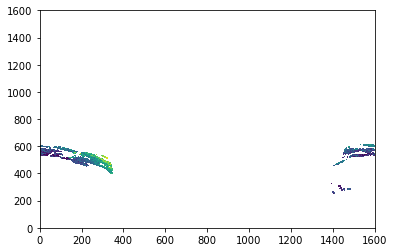

In [17]:
plt.pcolormesh(grid_array)

<ipython-input-18-aab5a1c993bc>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmin=0,latlon = True)


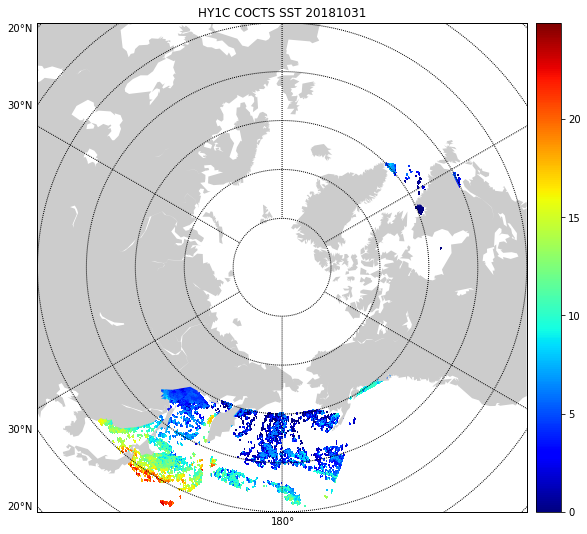

In [18]:
plt.figure(figsize=(16, 9))
hy_m = Basemap(projection='npaeqd', boundinglat=40, lon_0=180, resolution='c')
hy_m.pcolormesh(x_map, y_map, data=grid_array, cmap=plt.cm.jet,vmin=0,latlon = True)
hy_m.colorbar(location='right')
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY1C COCTS SST 20181031")
plt.show()
plt.close()